In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import pickle

/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


# dask

In [2]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
# Setupcloseur PBSCluster (Casper)
ncores=1
nmem='16GB'
cluster = PBSCluster(
    n_workers=16,
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='UMSU0012', # Input your project ID here
    walltime='00:10:00', # Amount of wall time
    interface='mgt', # Interface to use
)
# Setup your client
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/elkoukah/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/elkoukah/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.18.206.7:36053,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/elkoukah/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# analysis

In [4]:
archive_dir = '/glade/derecho/scratch/elkoukah/archive/'
casename = 'prod_swna_4km_new_surfdata_conus404.opt_002'

In [5]:
files = sorted(glob.glob(archive_dir+casename+'/lnd/hist/'+casename+'.clm2.h0.*.nc'))

In [6]:
ds0 = xr.open_dataset(files[1])
nbedrock = ds0['nbedrock'] # idx of bedrock layer soilwater=0

In [7]:
data_vars = ['RAIN', 'SNOW', 'TWS', 'QRUNOFF', 'QDRAI', 'QOVER', 'H2OSNO', 'QSNOMELT', 'FSNO',
             'QSOIL', 'QVEGT', 'QVEGE', 'TOTSOILLIQ', 'H2OSOI',
             'TOTSOILICE', 'SOILWATER_10CM', 'FSDS', 'FSR', 'FSA', 'FIRA', 'FLDS', 'FIRE']
def preprocess(ds):
    return ds[data_vars]
h0 = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)

tdelta = slice('1980-10', '2020-09')
h0 = h0.sel(time=tdelta).compute()

In [8]:
rnet = h0['FSA']-h0['FIRA']
# rnet = h0['FSDS']-h0['FSR']+h0['FLDS']-h0['FIRE']
h0['Rnet'] = rnet

asa = h0['FSR']/h0['FSDS']
h0['ASA'] = asa

prec = h0['RAIN']+h0['SNOW']
h0['PREC'] = prec

et = h0['QSOIL']+h0['QVEGT']+h0['QVEGE']
h0['ET'] = et

soilwater = h0['TOTSOILICE']+h0['TOTSOILLIQ']
h0['SM'] = soilwater

In [9]:
dz = np.array([0.02, 0.04, 0.06, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36,
       0.4 , 0.44, 0.54, 0.64, 0.74, 0.84, 0.94, 1.04, 1.14])

da_idx = xr.concat([nbedrock*0 + i for i in range(20)], dim='levsoi')
mask = (da_idx<nbedrock)
theta = h0['H2OSOI'].where(mask)
theta['levsoi'] = dz
theta_weighted = theta.weighted(theta['levsoi'])
theta_mean = theta_weighted.mean('levsoi') # verified for 39.32, -106.62+360

In [10]:
h0 = h0.drop_vars('H2OSOI')
# h0['theta'] = theta
h0['theta_wmean'] = theta_mean

In [11]:
h0_wy = h0.resample(time='A-SEP').mean()

h0_wy['QRUNOFF'] = h0_wy['QRUNOFF'].where(h0_wy['QRUNOFF']>0)

dict_h1 = pickle.load(open('out/h1_wy.pkl', 'rb'))
h0_wy['PX5D'] = dict_h1['PX5D']
h0_wy['SCF'] = dict_h1['SCF']

In [12]:
tdelta0 = slice('1980-10', '1999-09')
tdelta1 = slice('1999-10', '2020-09')

# wy
h0_meant0 = h0_wy.sel(time=tdelta0).mean('time')
h0_meant1 = h0_wy.sel(time=tdelta1).mean('time')

# sesonal
h0_ss0 = h0.sel(time=tdelta0).groupby('time.season').mean()
h0_ss1 = h0.sel(time=tdelta1).groupby('time.season').mean()

In [13]:
def calc_partition(da):
    da['Rain/P'] = da['RAIN']/da['PREC']
    da['R/P'] = da['QRUNOFF']/da['PREC']
    da['ET/P'] = da['ET']/da['PREC']
    da['C/P'] = da['QVEGT']/da['PREC']
    da['E/P'] = da['QSOIL']/da['PREC']
    da['S/P'] = (1-da['ET/P']+da['R/P'])
    for v in ('Rain/P','R/P','ET/P','C/P','E/P','S/P'):
        da[v] = da[v].where(da[v]<=1)
        da[v] = da[v].where(da[v]>=0)
    return da
h0_meant0 = calc_partition(h0_meant0)
h0_meant1 = calc_partition(h0_meant1)

In [14]:
cf = 365*24*60**2
da_prec = (h0_meant1['PREC']-h0_meant0['PREC'])*cf
da_snow = (h0_meant1['SNOW']-h0_meant0['SNOW'])*cf
da_rain = (h0_meant1['RAIN']-h0_meant0['RAIN'])*cf
da_px5d = (h0_meant1['PX5D']-h0_meant0['PX5D'])/h0_meant0['PX5D'] * 100
da_swe = (h0_meant1['H2OSNO']-h0_meant0['H2OSNO'])
# da_scf = (h0_meant1['SCF']-h0_meant0['SCF'])
da_et = (h0_meant1['ET']-h0_meant0['ET'])*cf
da_qtrans = (h0_meant1['QVEGT']-h0_meant0['QVEGT'])*cf
da_qsoil = (h0_meant1['QSOIL']-h0_meant0['QSOIL'])*cf
da_q = (h0_meant1['QRUNOFF']-h0_meant0['QRUNOFF'])*cf
da_qsurface = (h0_meant1['QOVER']-h0_meant0['QOVER'])*cf
da_qbase = (h0_meant1['QDRAI']-h0_meant0['QDRAI'])*cf
da_qmelt = (h0_meant1['QSNOMELT']-h0_meant0['QSNOMELT'])*cf
da_sm = (h0_meant1['SM']-h0_meant0['SM'])
da_sm_percent = (h0_meant1['SM']-h0_meant0['SM'])/h0_meant0['SM'] * 100
da_ssm = (h0_meant1['SOILWATER_10CM']-h0_meant0['SOILWATER_10CM'])
da_ssm_percent = (h0_meant1['SOILWATER_10CM']-h0_meant0['SOILWATER_10CM'])/h0_meant0['SOILWATER_10CM'] * 100
da_tws = (h0_meant1['TWS']-h0_meant0['TWS'])
da_smliq = (h0_meant1['TOTSOILLIQ']-h0_meant0['TOTSOILLIQ'])
da_smice = (h0_meant1['TOTSOILICE']-h0_meant0['TOTSOILICE'])
da_rnet = (h0_meant1['Rnet']-h0_meant0['Rnet'])*cf/(2.26*10**6)
da_fira = (h0_meant1['FIRA']-h0_meant0['FIRA'])*cf/(2.26*10**6)
da_fsa = (h0_meant1['FSA']-h0_meant0['FSA'])*cf/(2.26*10**6)

In [18]:
da_theta = (h0_meant1['theta_wmean']-h0_meant0['theta_wmean'])
da_theta_percent = (h0_meant1['theta_wmean']-h0_meant0['theta_wmean'])/h0_meant0['theta_wmean'] * 100

In [19]:
da_rainp = (h0_meant1['Rain/P']-h0_meant0['R/P'])*100
da_snowp = ((1-h0_meant1['Rain/P'])-(1-h0_meant0['R/P']))*100
da_rp = (h0_meant1['R/P']-h0_meant0['R/P'])*100
da_etp = (h0_meant1['ET/P']-h0_meant0['ET/P'])*100
da_ep = (h0_meant1['E/P']-h0_meant0['E/P'])*100
da_tp = (h0_meant1['C/P']-h0_meant0['C/P'])*100
da_smp = (h0_meant1['S/P']-h0_meant0['S/P'])*100

In [20]:
cf_ss = (365/4)*24*60**2
da_sm_ss = (h0_ss1['TOTSOILLIQ']-h0_ss0['TOTSOILLIQ'])
da_sm_ss_percent = (h0_ss1['TOTSOILLIQ']-h0_ss0['TOTSOILLIQ'])/h0_ss0['TOTSOILLIQ'] * 100
da_ssm_ss = (h0_ss1['SOILWATER_10CM']-h0_ss0['SOILWATER_10CM'])
da_tws_ss = (h0_ss1['TWS']-h0_ss0['TWS'])
da_prec_ss = (h0_ss1['PREC']-h0_ss0['PREC'])*cf_ss
da_rain_ss = (h0_ss1['RAIN']-h0_ss0['RAIN'])*cf_ss
da_snow_ss = (h0_ss1['SNOW']-h0_ss0['SNOW'])*cf_ss
da_prec_ss_percent = (h0_ss1['PREC']-h0_ss0['PREC'])/h0_ss0['PREC'] * 100
da_snowmelt_ss = (h0_ss1['QSNOMELT']-h0_ss0['QSNOMELT'])*cf_ss
da_snow_ss = (h0_ss1['SNOW']-h0_ss0['SNOW'])*cf_ss
da_swe_ss = (h0_ss1['H2OSNO']-h0_ss0['H2OSNO'])
da_et_ss = (h0_ss1['ET']-h0_ss0['ET'])*cf_ss
da_qsoil_ss = (h0_ss1['QSOIL']-h0_ss0['QSOIL'])*cf_ss
da_qtrans_ss = (h0_ss1['QVEGT']-h0_ss0['QVEGT'])*cf_ss
da_q_ss = (h0_ss1['QRUNOFF']-h0_ss0['QRUNOFF'])*cf_ss
da_qsurface_ss = (h0_ss1['QOVER']-h0_ss0['QOVER'])*cf_ss
da_qbase_ss = (h0_ss1['QDRAI']-h0_ss0['QDRAI'])*cf_ss
da_rnet_ss = (h0_ss1['Rnet']-h0_ss0['Rnet'])*cf_ss/(2.26*10**6)

# figure

In [21]:
# shapfile = '/glade/work/elkoukah/inputs/domain/shapefile/colorado_river_basin.shp'
shapfile = '/glade/work/elkoukah/inputs/domain/shapefile/wbd_SWUS_epsg4326.shp'
gdf = gpd.read_file(shapfile)
gdf_crs = gdf.to_crs(ccrs.PlateCarree())

In [22]:
shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_14_HU2_Shape/WBDHU2.shp'
gdf_ucrb = gpd.read_file(shapefile)
gdf_ucrb_crs = gdf_ucrb.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_15_HU2_Shape/WBDHU2.shp'
gdf_lcrb = gpd.read_file(shapefile)
gdf_lcrb_crs = gdf_lcrb.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_18_HU2_Shape/WBDHU2.shp'
gdf_ca = gpd.read_file(shapefile)
gdf_ca_crs = gdf_ca.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/SWUS_studydomain_epsg4326.shp'
gdf_sw = gpd.read_file(shapefile)
gdf_sw_crs = gdf_sw.to_crs(ccrs.PlateCarree())

In [23]:
gdf_sw_plot = pd.concat([gdf_ucrb, gdf_lcrb, gdf_ca, gdf_sw])
gdf_sw_plot = gdf_sw_plot.to_crs(ccrs.PlateCarree())

In [24]:
map_dict = {'precwy':(da_prec, np.arange(-100, 101, 20), '(mm)', r'$\Delta$ WY Precipitation'),
            'precjja':(da_prec_ss[1], np.arange(-100, 101, 20), '(mm)', r'$\Delta$ JJA Precipitation'),
            'px5d':(da_px5d, np.arange(-20, 21, 5), '(%)', r'$\Delta$ PX5D'),
           'snow':(da_snow, np.arange(-50, 51, 10), '(mm)', r'$\Delta$ WY Snowfall'),
           'swe':(da_swe, np.arange(-25, 26, 5), '(mm)', r'$\Delta$ WY Snow Water Equivalent'),
           'swemam':(da_swe_ss[2], np.arange(-25, 26, 5), '(mm)', r'$\Delta$ MAM Snow Water Equivalent'),
           'swejja':(da_swe_ss[1], np.arange(-25, 26, 5), '(mm)', r'$\Delta$ JJA Snow Water Equivalent'),
           'rnetjja':(da_rnet_ss[1], np.arange(-25, 26, 5), '(mm)', r'$\Delta$ JJA Rnet'),
           'qwy':(da_q, np.arange(-50, 51, 10), '(mm)', r'$\Delta$ WY Runoff'),
           'qmam':(da_q_ss[2], np.arange(-50, 51, 10), '(mm)', r'$\Delta$ MAM Runoff'),
           'qjja':(da_q_ss[1], np.arange(-50, 51, 10), '(mm)', r'$\Delta$ JJA Runoff'),
           'qswy':(da_qsurface, np.arange(-50, 51, 10), '(mm)', r'$\Delta$ WY Surface Runoff'),
           'etwy':(da_et, np.arange(-50, 51, 10), '(mm)', r'$\Delta$ WY Evapotranspiration'),
           'etmam':(da_et_ss[2], np.arange(-50, 51, 10), '(mm)', r'$\Delta$ MAM Evapotranspiration'),
           'etjja':(da_et_ss[1], np.arange(-50, 51, 10), '(mm)', r'$\Delta$ JJA Evapotranspiration'),
           'qsoiljja':(da_qsoil_ss[1], np.arange(-50, 51, 10), '(mm)', r'$\Delta$ JJA Soil Evaporation'),
           'qsoilmam':(da_qsoil_ss[2], np.arange(-50, 51, 10), '(mm)', r'$\Delta$ MAM Soil Evaporation'),
           'qmelt':(da_qmelt, np.arange(-50, 51, 10), '(mm)', r'$\Delta$ WY Snowmelt'),
           'qmeltdjf':(da_snowmelt_ss[0], np.arange(-50, 51, 10), '(mm)', r'$\Delta$ DJF Snowmelt'),
           'qmeltmam':(da_snowmelt_ss[2], np.arange(-50, 51, 10), '(mm)', r'$\Delta$ MAM Snowmelt'),
           'qmeltjja':(da_snowmelt_ss[1], np.arange(-50, 51, 10), '(mm)', r'$\Delta$ JJA Snowmelt'),
           'smwy':(da_sm_percent, np.arange(-20, 21, 5), '(%)', r'$\Delta$ WY Total Soil Water Content'),
           'smjja':(da_sm_ss_percent[1], np.arange(-20, 21, 5), '(%)', r'$\Delta$ JJA Total Soil Water Content'),
           'smmam':(da_sm_ss_percent[2], np.arange(-20, 21, 5), '(%)', r'$\Delta$ MAM Total Soil Water Content'),
           'thetawy':(da_theta_percent, np.arange(-20, 21, 5), '(%)', r'$\Delta$ WY Vol Soil Water Content'),
          }

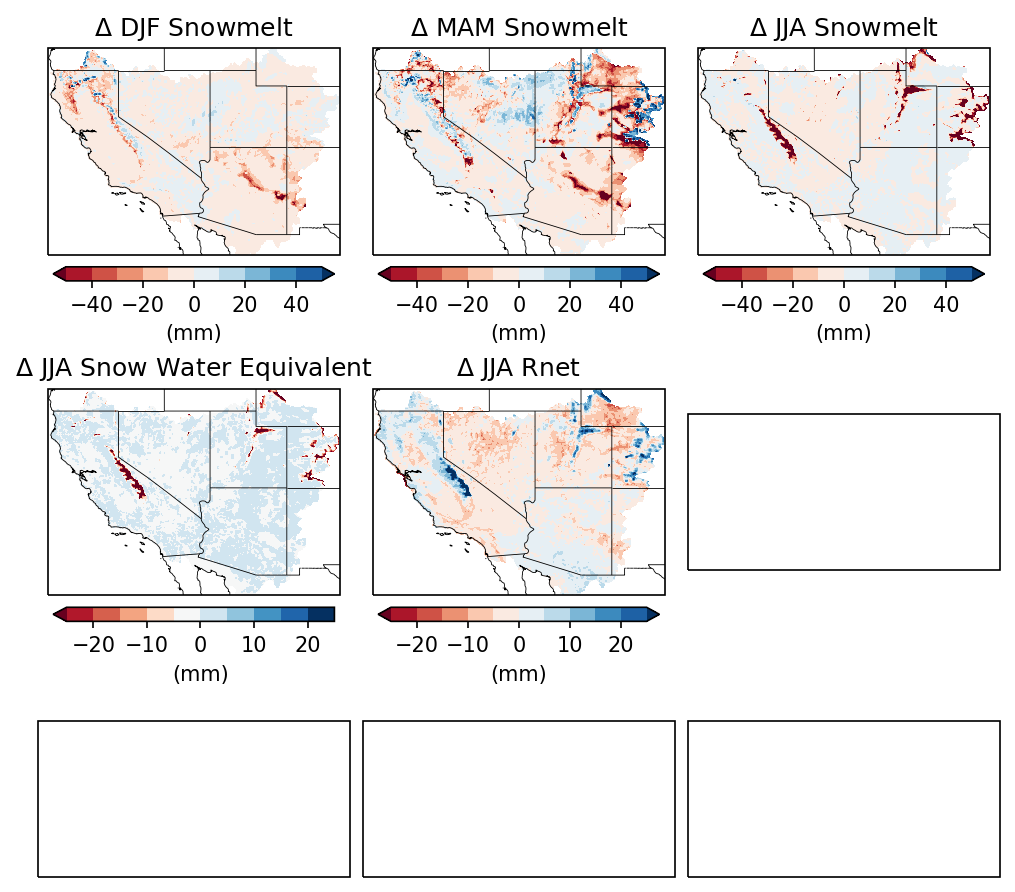

In [25]:
fig, axes = plt.subplots(3,3, figsize=(6.5,6), dpi=150, constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.PlateCarree()))
extent = (-124.6, -105.6, 30.02, 43.46)
cmap = 'RdBu'
states_provinces = cfeature.NaturalEarthFeature(category='cultural', 
                                                name='admin_1_states_provinces_lines', 
                                                scale='50m', facecolor='none')
variables = ['qmeltdjf', 'qmeltmam', 'qmeltjja', 'swejja','rnetjja']
for var, ax in zip(variables, axes.ravel()):
    da, levels, cbarlabel, title = map_dict[var]
    cbar_dict = dict(label=cbarlabel, shrink=.9, location='bottom')
    cf = da.plot.contourf(ax=ax, levels=levels, cmap=cmap, cbar_kwargs=cbar_dict)
    ax.add_feature(cfeature.BORDERS, lw=.4)
    ax.add_feature(cfeature.COASTLINE, zorder=1, lw=.4)
    ax.add_feature(states_provinces, edgecolor='k', lw=.4, zorder=1)
    # gdf_crs.plot(ax=ax, lw=0.2, facecolor='None', edgecolor='k')
    ax.set_extent(extent)
    ax.set_title(title)
    # if var=='snow': break

In [18]:
# seasonality

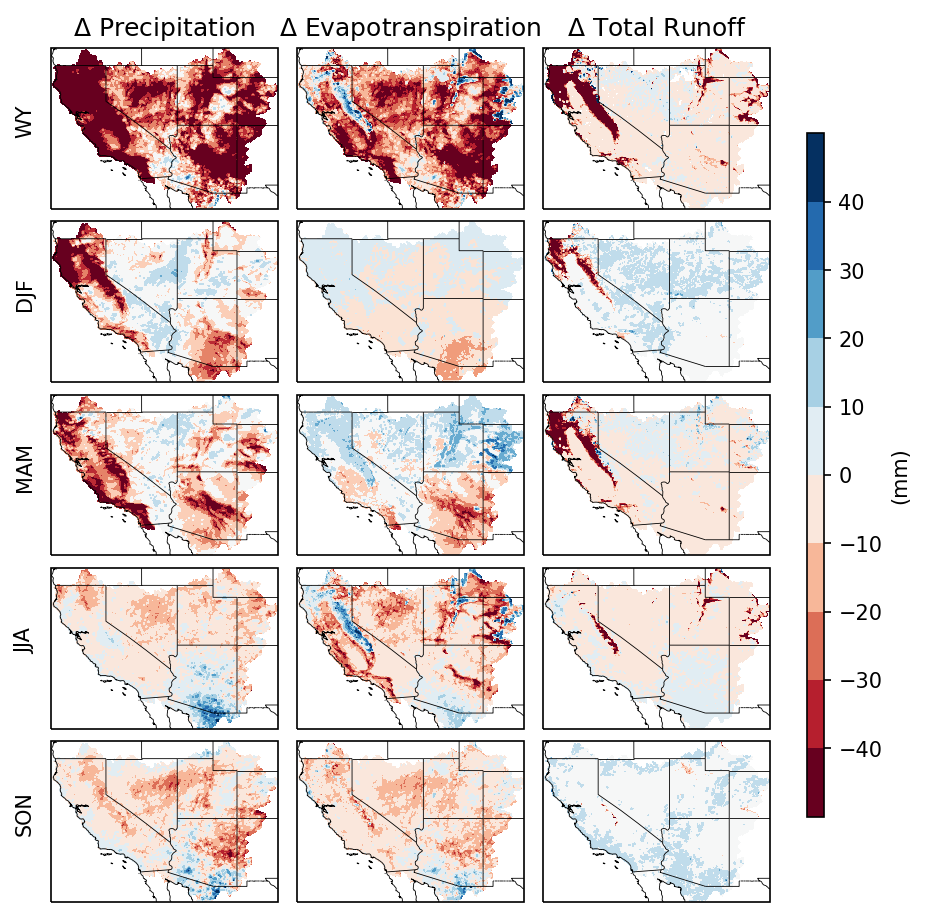

In [26]:
fig, axes = plt.subplots(5,3, figsize=(6.,6), dpi=150, constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.PlateCarree()))
extent = (-124.6, -105.6, 30.02, 43.46)
cmap = 'RdBu'
states_provinces = cfeature.NaturalEarthFeature(category='cultural', 
                                                name='admin_1_states_provinces_lines', 
                                                scale='50m', facecolor='none')
levels = np.arange(-40, 41, 10)
norm = mpl.colors.TwoSlopeNorm(vmin=-40, vcenter=0, vmax=40)
da_tuple = (da_prec, da_et, da_q)
titles = (r'$\Delta$ Precipitation', r'$\Delta$ Evapotranspiration', r'$\Delta$ Total Runoff')
for ax, da, title in zip(axes[0], da_tuple, titles):
    cf = da.plot.contourf(ax=ax, levels=levels, cmap=cmap, norm=norm, add_colorbar=False)
    # gdf_sw_plot.plot(ax=ax, lw=0.2, facecolor='None', edgecolor='k')
    ax.add_feature(cfeature.BORDERS, lw=.4)
    ax.add_feature(cfeature.COASTLINE, zorder=1, lw=.4)
    ax.add_feature(states_provinces, edgecolor='k', lw=.4, zorder=1)
    ax.set_extent(extent)
    ax.set_title(title)

ax = axes[0,0]
ax.text(-0.07, 0.55, 'WY', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)

plt.colorbar(cf, ax=axes, label='(mm)', location='right', aspect=40, shrink=.8, norm=norm,
            extendfrac='auto', extendrect=True,)

idx = (0,2,1,3)
da_tuple = (da_prec_ss, da_et_ss, da_q_ss)
ylabels = ['DJF','MAM','JJA','SON']
for j in range(3):
    for i in range(4):
        ax = axes[i+1, j]
        da = da_tuple[j][idx[i]]
        cf = da.plot.contourf(ax=ax, levels=levels, cmap=cmap, norm=norm, add_colorbar=False)
        # gdf_sw_plot.plot(ax=ax, lw=0.2, facecolor='None', edgecolor='k')
        ax.add_feature(cfeature.BORDERS, lw=.4)
        ax.add_feature(cfeature.COASTLINE, zorder=1, lw=.4)
        ax.add_feature(states_provinces, edgecolor='k', lw=.4, zorder=1)
        ax.set_extent(extent)
        ax.set_title('')
        if j==0:
            ax.text(-0.07, 0.55, ylabels[i], va='bottom', ha='center',
                    rotation='vertical', rotation_mode='anchor',
                    transform=ax.transAxes)

In [135]:
fig.savefig('./figs/re_changes_fluxes.png', dpi=600, bbox_inches='tight')

In [27]:
def grid_cell_percent(x,y,t=96671):
    c0 = int(((x<0)*(y<0)).sum()/t * 100)
    c1 = int(((x>0)*(y>0)).sum()/t * 100)
    c2 = int(((x<0)*(y>0)).sum()/t * 100)
    c3 = int(((x>0)*(y<0)).sum()/t * 100)
    return np.array([c0, c1, c2, c3])

(-250.0, 50.0)

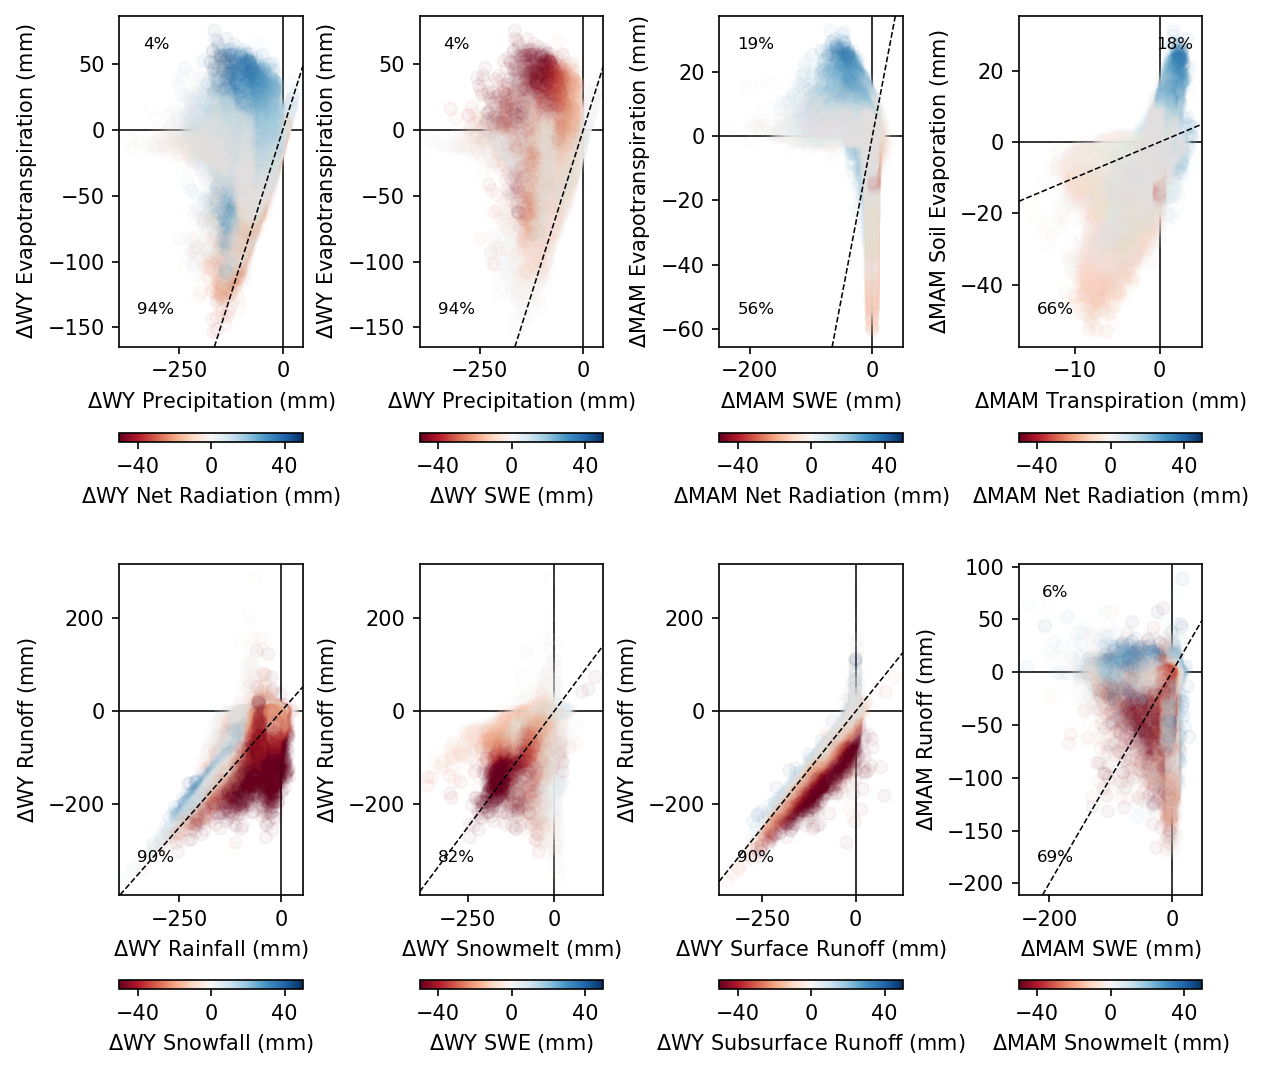

In [26]:
fig, axes = plt.subplots(2,4, figsize=(8,7), dpi=150, constrained_layout=True,
                        gridspec_kw={'hspace':.1})
plot_tuple = (
    ((da_et, da_prec, da_rnet), (r'$\Delta$WY Evapotranspiration (mm)', r'$\Delta$WY Precipitation (mm)', r'$\Delta$WY Net Radiation (mm)')),
    ((da_et, da_prec, da_swe), (r'$\Delta$WY Evapotranspiration (mm)', r'$\Delta$WY Precipitation (mm)', r'$\Delta$WY SWE (mm)')),
    ((da_et_ss[2], da_swe_ss[2], da_rnet_ss[2]), (r'$\Delta$MAM Evapotranspiration (mm)', r'$\Delta$MAM SWE (mm)', r'$\Delta$MAM Net Radiation (mm)')),
    ((da_qsoil_ss[2], da_qtrans_ss[2], da_rnet_ss[2]), (r'$\Delta$MAM Soil Evaporation (mm)', r'$\Delta$MAM Transpiration (mm)', r'$\Delta$MAM Net Radiation (mm)')),
    ((da_q, da_rain, da_snow), (r'$\Delta$WY Runoff (mm)', r'$\Delta$WY Rainfall (mm)', r'$\Delta$WY Snowfall (mm)')),
    ((da_q, da_qmelt, da_swe), (r'$\Delta$WY Runoff (mm)', r'$\Delta$WY Snowmelt (mm)', r'$\Delta$WY SWE (mm)')),
    ((da_q, da_qsurface, da_qbase), (r'$\Delta$WY Runoff (mm)', r'$\Delta$WY Surface Runoff (mm)', r'$\Delta$WY Subsurface Runoff (mm)')),
    ((da_q_ss[2], da_swe_ss[2], da_snowmelt_ss[2]), (r'$\Delta$MAM Runoff (mm)', r'$\Delta$MAM SWE (mm)', r'$\Delta$MAM Snowmelt (mm)')),
    # ((da_sm_percent, da_prec_ss[1], da_et_ss[1]), (r'$\Delta$ Soil Water Content (mm)', r'$\Delta$ JJA Precipitation (mm)', r'$\Delta$ JJA Evapotranspiration (mm)')),
             )
norm = mpl.colors.TwoSlopeNorm(vmin=-50, vcenter=0, vmax=50)
selp = [[0,2],[0,2],[0,2],[0,1],
        [0],[0],[0],[0,2],]
coords = np.array([(0.2,0.1),(0.85, 0.9),(0.2,0.9),(0.8,0.1)])
tmp = range(8)
for i in tmp:
    ax = axes.ravel()[i]
    (y, x, z), (ylabel, xlabel, zlabel) = plot_tuple[i]
    x = x.stack(ngrd=('lat','lon'))
    y = y.stack(ngrd=('lat','lon'))
    z = z.stack(ngrd=('lat','lon'))#.dropna('ngrd')
    percents = grid_cell_percent(x,y)
    for xy,c in zip(coords[selp[i]], percents[selp[i]]):
        ax.annotate(str(c)+'%', xy=xy, xycoords='axes fraction', fontsize=8, ha='center')
    ax.scatter(x, y, c=plt.cm.RdBu(norm(z)), alpha=0.04)
    ax.axhline(0, c='k', lw=.75, zorder=-1)
    ax.axvline(0, c='k', lw=.75, zorder=-1)
    ax.axline((0, 0), slope=1, c='k', lw=.75, ls='--')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm._A = []
    plt.colorbar(sm, ax=ax, label=zlabel, location='bottom', ticks=[-40,0,40])
    # if i==1: break
axes[0,2].set_xlim(-250,50)
axes[1,3].set_xlim(-250,50)

In [27]:
fig.savefig('./figs/re_spatial_scatter.png', dpi=600, bbox_inches='tight')

(-250.0, 50.0)

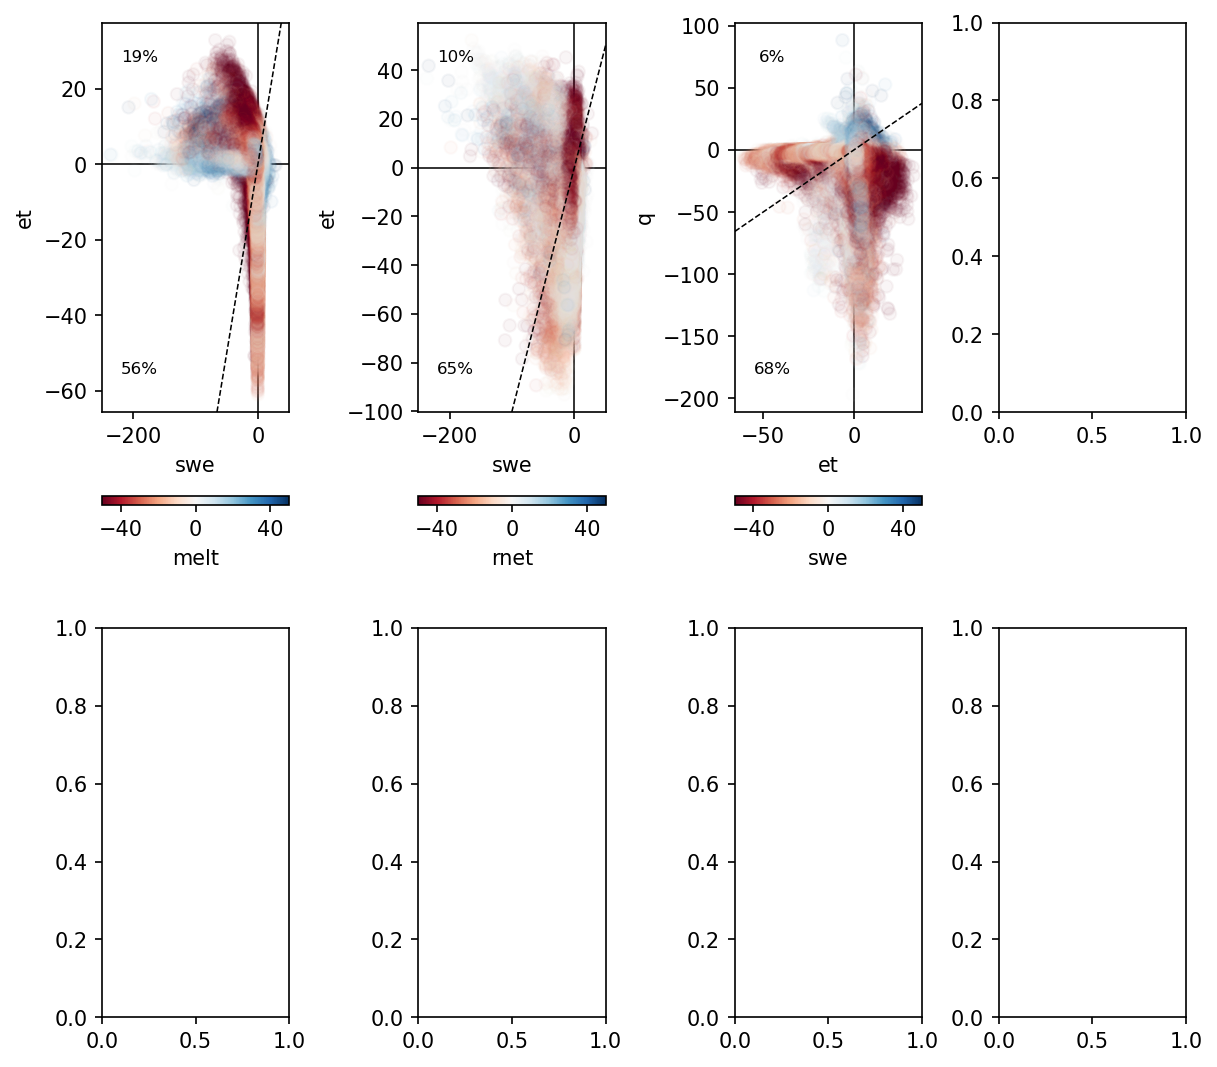

In [32]:
fig, axes = plt.subplots(2,4, figsize=(8,7), dpi=150, constrained_layout=True,
                        gridspec_kw={'hspace':.1})
plot_tuple = (
    ((da_et_ss[2], da_swe_ss[2], da_snowmelt_ss[2]), ('et','swe','melt')),
    ((da_et_ss[1], da_swe_ss[2], da_q_ss[2]), ('et','swe','rnet')),
    ((da_q_ss[2], da_et_ss[2], da_snowmelt_ss[2]), ('q','et','swe')),
    ((da_et, da_prec, da_swe), (r'$\Delta$WY Evapotranspiration (mm)', r'$\Delta$WY Precipitation (mm)', r'$\Delta$WY SWE (mm)')),
    ((da_et_ss[2], da_swe_ss[2], da_rnet_ss[2]), (r'$\Delta$MAM Evapotranspiration (mm)', r'$\Delta$MAM SWE (mm)', r'$\Delta$MAM Net Radiation (mm)')),
    ((da_qsoil_ss[2], da_qtrans_ss[2], da_rnet_ss[2]), (r'$\Delta$MAM Soil Evaporation (mm)', r'$\Delta$MAM Transpiration (mm)', r'$\Delta$MAM Net Radiation (mm)')),
    ((da_q, da_rain, da_snow), (r'$\Delta$WY Runoff (mm)', r'$\Delta$WY Rainfall (mm)', r'$\Delta$WY Snowfall (mm)')),
    ((da_q, da_qmelt, da_swe), (r'$\Delta$WY Runoff (mm)', r'$\Delta$WY Snowmelt (mm)', r'$\Delta$WY SWE (mm)')),
    ((da_q, da_qsurface, da_qbase), (r'$\Delta$WY Runoff (mm)', r'$\Delta$WY Surface Runoff (mm)', r'$\Delta$WY Subsurface Runoff (mm)')),
    ((da_q_ss[2], da_swe_ss[2], da_snowmelt_ss[2]), (r'$\Delta$MAM Runoff (mm)', r'$\Delta$MAM SWE (mm)', r'$\Delta$MAM Snowmelt (mm)')),
    # ((da_sm_percent, da_prec_ss[1], da_et_ss[1]), (r'$\Delta$ Soil Water Content (mm)', r'$\Delta$ JJA Precipitation (mm)', r'$\Delta$ JJA Evapotranspiration (mm)')),
             )
norm = mpl.colors.TwoSlopeNorm(vmin=-50, vcenter=0, vmax=50)
selp = [[0,2],[0,2],[0,2],[0,1],
        [0],[0],[0],[0,2],]
coords = np.array([(0.2,0.1),(0.85, 0.9),(0.2,0.9),(0.8,0.1)])
tmp = range(3)
for i in tmp:
    ax = axes.ravel()[i]
    (y, x, z), (ylabel, xlabel, zlabel) = plot_tuple[i]
    x = x.stack(ngrd=('lat','lon'))
    y = y.stack(ngrd=('lat','lon'))
    z = z.stack(ngrd=('lat','lon'))#.dropna('ngrd')
    percents = grid_cell_percent(x,y)
    for xy,c in zip(coords[selp[i]], percents[selp[i]]):
        ax.annotate(str(c)+'%', xy=xy, xycoords='axes fraction', fontsize=8, ha='center')
    ax.scatter(x, y, c=plt.cm.RdBu(norm(z)), alpha=0.04)
    ax.axhline(0, c='k', lw=.75, zorder=-1)
    ax.axvline(0, c='k', lw=.75, zorder=-1)
    ax.axline((0, 0), slope=1, c='k', lw=.75, ls='--')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm._A = []
    plt.colorbar(sm, ax=ax, label=zlabel, location='bottom', ticks=[-40,0,40])
    # if i==1: break
axes[0,0].set_xlim(-250,50)
axes[0,1].set_xlim(-250,50)
# axes[0,2].set_xlim(-250,50)
# axes[1,3].set_xlim(-250,50)

In [ ]:
# stats

In [74]:
fsnow = (h0_wy['SNOW'].mean('time')/h0_wy['PREC'].mean('time'))*100
y = da_snowp.where(fsnow>10)
(y<0).sum()/(~y.isnull()).sum()


<xarray.DataArray ()>
array(0.93318969)

In [39]:
fevap = (h0_wy['QSOIL'].mean('time')/h0_wy['ET'].mean('time'))*100
# fevap.mean()
# (da_et>0).sum()/(~da_et.isnull()).sum()
(da_et_ss[2]>0).sum()/(~da_et.isnull()).sum()
# (da_et_ss[2]>0).sum()/(~da_et.isnull()).sum()

<xarray.DataArray 'ET' ()>
array(0.25530924)
Coordinates:
    season   <U3 'MAM'

In [24]:
dict_res_basin_mask = pickle.load(open('out/dict_res_basin_mask.pkl', 'rb'))
mask = dict_res_basin_mask['597']
h0_wy_basin = h0_wy.stack(ngrd=('lat','lon')).sel(ngrd=(mask>0))

In [26]:
# fqsurface = (h0_wy['QOVER'].mean('time')/h0_wy['QRUNOFF'].mean('time'))*100
# fqsurface.plot.hist()
# fq = h0_wy['QSOIL'].mean('time').sum()/h0_wy['ET'].mean('time').sum()
# fq = h0_wy['QOVER'].mean('time').sum()/h0_wy['QRUNOFF'].mean('time').sum()
fq = h0_wy_basin['QOVER'].mean('time').sum()/h0_wy_basin['QRUNOFF'].mean('time').sum()
fq

<xarray.DataArray ()>
array(0.92562413, dtype=float32)

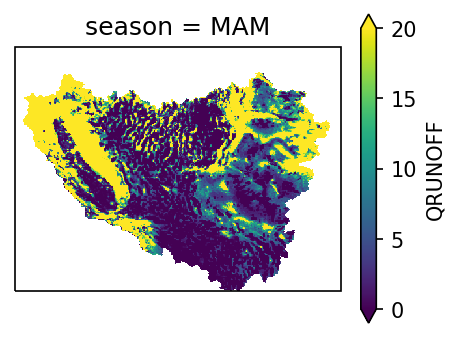

In [45]:
fig = plt.figure(dpi=150, figsize=(3.5,6))
ax = plt.subplot(211, projection=ccrs.PlateCarree())
(h0_ss1['QRUNOFF'][2]*cf_ss).plot(vmin=0, vmax=20, ax=ax)

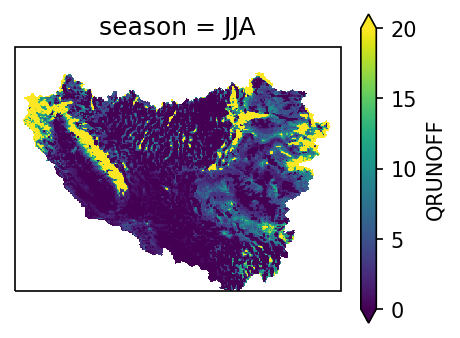

In [46]:
fig = plt.figure(dpi=150, figsize=(3.5,6))
ax = plt.subplot(211, projection=ccrs.PlateCarree())
(h0_ss1['QRUNOFF'][1]*cf_ss).plot(vmin=0, vmax=20, ax=ax)

<GeoAxesSubplot:title={'center':'season = MAM'}, xlabel='lon', ylabel='lat'>

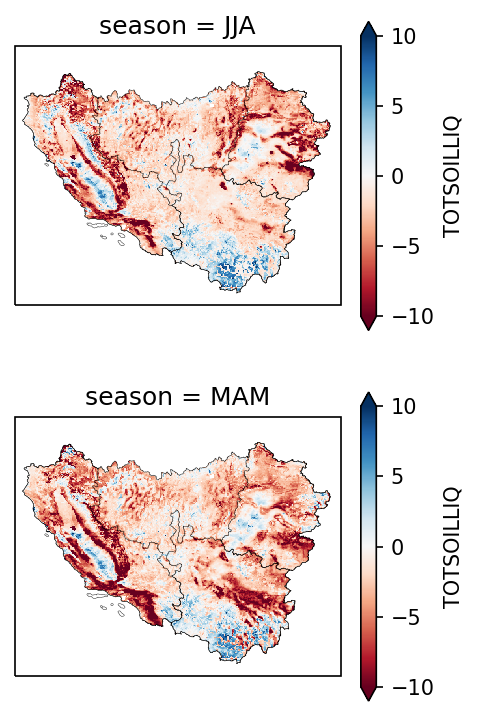

In [77]:
fig = plt.figure(dpi=150, figsize=(3.5,6))
ax = plt.subplot(211, projection=ccrs.PlateCarree())
h0_ss0['QRUNOFF'][0].plot(vmin=-10, vmax=10, cmap='RdBu', ax=ax)
gdf_sw_plot.plot(ax=ax, lw=0.2, facecolor='None', edgecolor='k')
ax = plt.subplot(212, projection=ccrs.PlateCarree())
da_sm_ss_percent[2].plot(vmin=-10, vmax=10, cmap='RdBu', ax=ax)
gdf_sw_plot.plot(ax=ax, lw=0.2, facecolor='None', edgecolor='k')

In [29]:
import matplotlib.gridspec as gridspec

In [54]:
plot_tuple = (
    ((da_sm_ss_percent[2], da_prec_ss[1], da_swe_ss[2]), (r'$\Delta$WY Soil Water Content (%)', r'$\Delta$JJA Precipitation (mm)', r'$\Delta$MAM SWE (mm)')),
    # ((da_sm_percent, da_prec_ss[1], da_swe_ss[2]), (r'$\Delta$WY Soil Water Content (%)', r'$\Delta$JJA Precipitation (mm)', r'(mm)')),
)

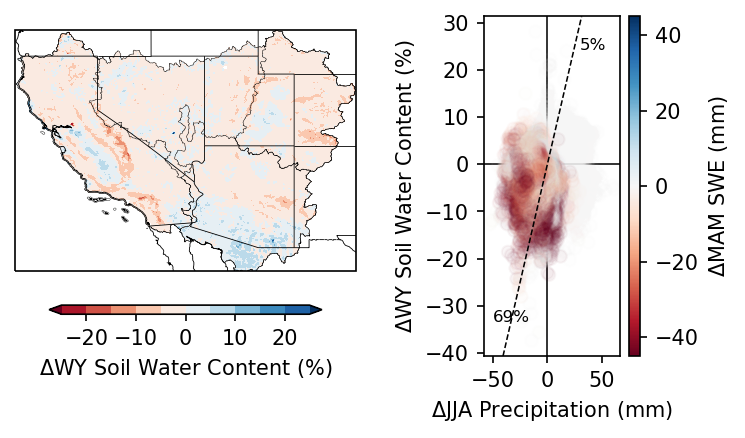

In [55]:
fig = plt.figure(figsize=(5.5,3), dpi=150)
gspec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig, width_ratios=[1,.5], wspace=.5)

ax = plt.subplot(gspec[0,0], projection=ccrs.PlateCarree())
levels = np.arange(-25, 26, 5)
extent = (-124.6, -105.6, 30.02, 43.46)
cmap = 'RdBu'
cbarlabel = r'$\Delta$WY Soil Water Content (%)'
cbar_kw = dict(label=cbarlabel, location='bottom', shrink=.8, aspect=30, pad=0.1)
states_provinces = cfeature.NaturalEarthFeature(category='cultural', 
                                                name='admin_1_states_provinces_lines', 
                                                scale='50m', facecolor='none')
cf = da_sm_percent.plot.contourf(ax=ax, levels=levels, cmap=cmap, add_colorbar=True,
                                cbar_kwargs=cbar_kw)
gdf_sw_plot.plot(ax=ax, lw=0.2, facecolor='None', edgecolor='k')
ax.add_feature(cfeature.BORDERS, lw=.4)
ax.add_feature(cfeature.COASTLINE, zorder=1, lw=.4)
ax.add_feature(states_provinces, edgecolor='k', lw=.4, zorder=1)
ax.set_extent(extent)
ax.set_title('')

norm = mpl.colors.TwoSlopeNorm(vmin=-45, vcenter=0, vmax=45)
# for i in [1]:
ax = plt.subplot(gspec[0,1])
(y, x, z), (ylabel, xlabel, zlabel) = plot_tuple[0]
x = x.stack(ngrd=('lat','lon'))
y = y.stack(ngrd=('lat','lon'))
z = z.stack(ngrd=('lat','lon'))#.dropna('ngrd')
percents = grid_cell_percent(x,y)
coords = np.array([(0.2,0.1),(0.8, 0.9),(0.2,0.9),(0.8,0.1)])
for xy,c in zip(coords[[0,1]],percents[[0,1]]):
    ax.annotate(str(c)+'%', xy=xy, xycoords='axes fraction', fontsize=8, ha='center')
ax.scatter(x, y, c=plt.cm.RdBu(norm(z)), alpha=0.04)
ax.axhline(0, c='k', lw=.75, zorder=-1)
ax.axvline(0, c='k', lw=.75, zorder=-1)
ax.axline((0, 0), slope=1, c='k', lw=.75, ls='--')
ax.set_ylabel(ylabel)
ax.set_xlabel(xlabel)
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
sm._A = []
plt.colorbar(sm, ax=ax, label=zlabel, location='right', aspect=30, ticks=[-40,-20,0,20,40])

In [148]:
fig.savefig('./figs/re_soilmoisture_mapscatter.png', dpi=600, bbox_inches='tight')

In [65]:
da_dict = {'prec':(da_prec, np.arange(-100, 101, 20), '(mm)', 'Precipitation'),
           'snow':(da_snow, np.arange(-50, 51, 10), '(mm)', 'Snowfall'),
           'swe':(da_swe, np.arange(-25, 26, 2.5), '(mm)', 'Snow Water Equivalent'),
           'qmelt':(da_qmelt, np.arange(-50, 51, 10), '(mm)', 'Snowmelt'),
           'et':(da_et, np.arange(-50, 51, 10), '(mm)', 'Evapotranspiration'),
           'qtrans':(da_qtrans, np.arange(-25, 26, 5), '(mm)', 'Transpiration'),
           'qsoil':(da_qsoil, np.arange(-25, 26, 5), '(mm)', 'Evaporation'),
           'q':(da_q, np.arange(-50, 51, 10), '(mm)', 'Runoff'),
           'qsurface':(da_qsurface, np.arange(-25, 26, 5), '(mm)', 'Surface Runoff'),
           'qbase':(da_qbase, np.arange(-25, 26, 5), '(mm)', 'Subsurface Runoff'),
           'sm':(da_sm, np.arange(-50, 51, 10), '(mm)', 'Soil Water Content'),
           'smliq':(da_smliq, np.arange(-50, 51, 10), '(mm)', 'Soil Water Content (liquid)'),
           'smice':(da_smice, np.arange(-5, 5, 1), '(mm)', 'Soil Water Content (Ice)'),
          }

In [22]:
shapfile = '/glade/work/elkoukah/inputs/domain/shapefile/colorado_river_basin.shp'
shapfile = '/glade/work/elkoukah/inputs/domain/shapefile/wbd_SWUS_epsg4326.shp'
gdf = gpd.read_file(shapfile)
gdf_crs = gdf.to_crs(ccrs.PlateCarree())
# sel_gdf = [gdf[gdf['huc4']==huc4] for huc4 in gdf['huc4'] 
#            if huc4.startswith('14') or huc4.startswith('15') or huc4.startswith('18')]
# sel_gdf = pd.concat(sel_gdf)

In [67]:
# from shapely.ops import unary_union
# multipolygon = unary_union(gdf_crs.geometry)
# gdf_crs_union = gpd.GeoDataFrame({'geometry': [multipolygon]})

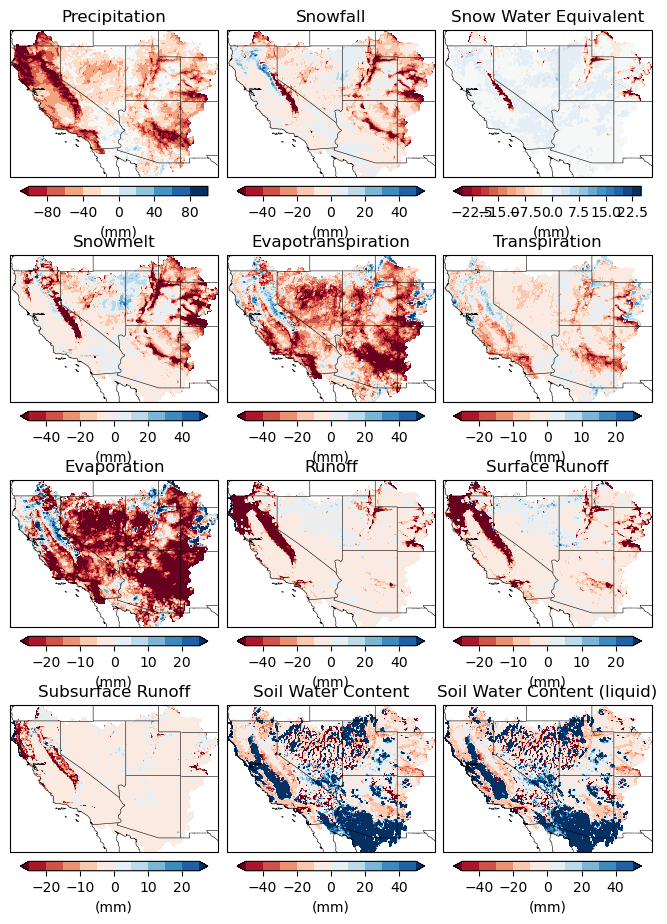

In [68]:
fig, axes = plt.subplots(4,3, figsize=(6.5,9), dpi=100, constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.PlateCarree()))
extent = (-124.6, -105.6, 30.02, 43.46)
cmap = 'RdBu'
states_provinces = cfeature.NaturalEarthFeature(category='cultural', 
                                                name='admin_1_states_provinces_lines', 
                                                scale='50m', facecolor='none')
variables = list(da_dict.keys())
for i, ax in enumerate(axes.ravel()):
    da, levels, cbarlabel, title = da_dict[variables[i]]
    cbar_dict = dict(label=cbarlabel, shrink=.9, location='bottom')
    cf = da.plot.contourf(ax=ax, levels=levels, cmap=cmap, cbar_kwargs=cbar_dict)
    ax.add_feature(cfeature.BORDERS, lw=.4)
    ax.add_feature(cfeature.COASTLINE, zorder=1, lw=.4)
    ax.add_feature(states_provinces, edgecolor='k', lw=.4, zorder=1)
    # gdf_crs.plot(ax=ax, lw=0.2, facecolor='None', edgecolor='k')
    ax.set_extent(extent)
    ax.set_title(title)
    # if i==2: break